
[INFO] Loading datasets...
Train Wide: (396, 2836), Train Long: (38385, 105)
Val Wide: (85, 2836), Val Long: (8047, 105)
Test Wide: (86, 2836), Test Long: (8737, 105)
Raw PCL-5 sample (first 5 rows):
   WK8_PCL5_RS  M3_PCL5_RS  M6_PCL5_RS  PRE_PCL5_RS  WK2_PCL5_RS
1         41.0         NaN         NaN         68.0         59.0
2          0.0         0.0         0.0         16.0          4.0
3          NaN         NaN         NaN          NaN          NaN
4         33.0        38.0        20.0         48.0         46.0
5          0.0         5.0         7.0          NaN          NaN
Max raw PCL-5 values: WK8_PCL5_RS    80.0
M3_PCL5_RS     80.0
M6_PCL5_RS     75.0
PRE_PCL5_RS    78.0
WK2_PCL5_RS    77.0
dtype: float64
Min raw PCL-5 values: WK8_PCL5_RS    0.0
M3_PCL5_RS     0.0
M6_PCL5_RS     0.0
PRE_PCL5_RS    3.0
WK2_PCL5_RS    0.0
dtype: float64
y mean (pre-impute): [28.59818731 24.17956656 23.11447811], SD: [18.67285207 17.75299958 18.72574595]
y mean (post-impute): [28.78673136 24.

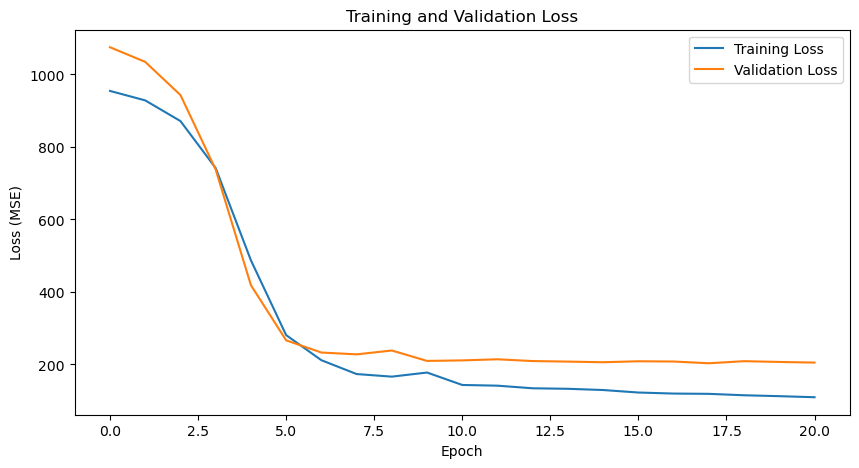


--- Model Evaluation ---
WK8_PCL5_RS - MAE: 10.9864, RMSE: 14.3124, R²: 0.3594
M3_PCL5_RS - MAE: 12.0692, RMSE: 15.5484, R²: 0.2527
M6_PCL5_RS - MAE: 11.7741, RMSE: 15.1866, R²: 0.2943

--- Classification Metrics (PCL-5 > 33) ---
              precision    recall  f1-score   support

 WK8_PCL5_RS       0.81      0.69      0.75        32
  M3_PCL5_RS       0.78      0.58      0.67        31
  M6_PCL5_RS       0.73      0.55      0.63        29

   micro avg       0.78      0.61      0.68        92
   macro avg       0.77      0.61      0.68        92
weighted avg       0.78      0.61      0.68        92
 samples avg       0.24      0.24      0.23        92


--- All Test Predictions ---
Total test set size: 86 rows

PID: 100542
WK8_PCL5_RS - Actual: 48.00, Predicted: 22.51
M3_PCL5_RS - Actual: 43.80, Predicted: 19.87
M6_PCL5_RS - Actual: 39.20, Predicted: 18.58

PID: 100745
WK8_PCL5_RS - Actual: 8.00, Predicted: 14.74
M3_PCL5_RS - Actual: 5.00, Predicted: 12.24
M6_PCL5_RS - Actual: 12.

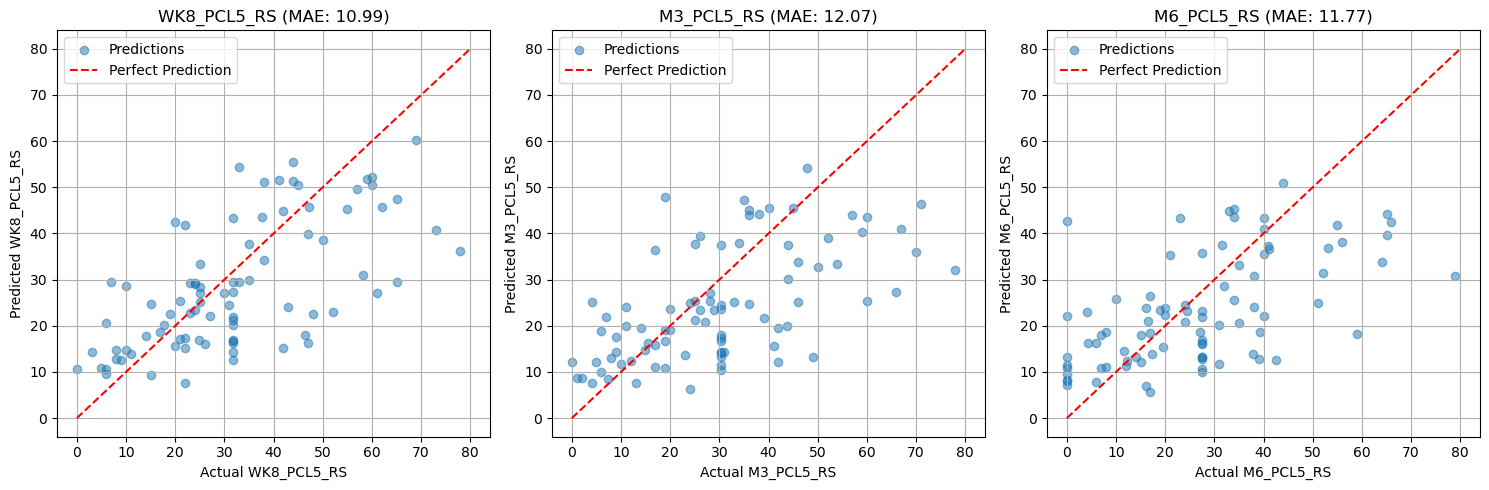

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow GPU warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, LayerNormalization, Concatenate, Multiply
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt
import warnings

# Suppress warnings *after* imports
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Step 1--- DATASET PY ----
def load_and_split_data():
    print("\n[INFO] Loading datasets...")
    wide_df = pd.read_csv("/projects/dsci410_510/Aurora/widegpsptsd.csv", low_memory=False)
    long_df = pd.read_csv("/projects/dsci410_510/Aurora/longgpsliwc.csv", low_memory=False)
    
    numeric_cols = wide_df.columns[wide_df.columns.str.contains('PCL5|ChanceofDying|Age|PSS10|PhenX|AnxBank|Dep8b|Pain4a|Somatic|CDRISC10|PCS_Rum|PSQI|SleepImp|ISI|BMI|Stress', regex=True)]
    for col in numeric_cols:
        if col in wide_df.columns:
            wide_df[col] = pd.to_numeric(wide_df[col], errors='coerce')
    
    long_df["Time_Label"] = long_df["day"].apply(lambda x: "PRE" if x <= 0 else "WK2" if x <= 14 else "WK8" if x <= 56 else "M3" if x <= 90 else "M6" if x <= 180 else None)
    long_df = long_df[long_df["Time_Label"].notna()]
    
    train_pids, temp_pids = train_test_split(wide_df["PID"].unique(), test_size=0.30, random_state=42069)
    val_pids, test_pids = train_test_split(temp_pids, test_size=0.50, random_state=42069)
    
    train_wide = wide_df[wide_df["PID"].isin(train_pids)]
    val_wide = wide_df[wide_df["PID"].isin(val_pids)]
    test_wide = wide_df[wide_df["PID"].isin(test_pids)]
    
    train_long = long_df[long_df["PID"].isin(train_pids)]
    val_long = long_df[long_df["PID"].isin(val_pids)]
    test_long = long_df[long_df["PID"].isin(test_pids)]
    
    print(f"Train Wide: {train_wide.shape}, Train Long: {train_long.shape}")
    print(f"Val Wide: {val_wide.shape}, Val Long: {val_long.shape}")
    print(f"Test Wide: {test_wide.shape}, Test Long: {test_long.shape}")
    
    return train_long, train_wide, val_long, val_wide, test_long, test_wide

# --- PREPROCESS DATA ---
def preprocess_data(long_df, wide_df):
    ts_features = ['dist_traveled', 'radius', 'num_sig_places', 'av_flight_length', 'LIWC_posemo', 'LIWC_anger', 'LIWC_sad']
    static_features = [
        'ED_ChanceofDying', 'WK2_PROM_AnxBank_RS', 'WK2_SCRN_GAD_RS', 'WK2_BriefPCL', 'WK2_ASD_RS',
        'ED_ChiefPain_MuscSkel', 'ED_ChiefPain_Neck', 'ED_ChiefPain_Headache', 'PRE_PROM_Pain4a_T',
        'WK2_PROM_Pain4a_T', 'PRE_Somatic_YN_COUNT', 'WK2_Somatic_YN_COUNT', 'PRE_PhenX_Tob30d_Freq',
        'WK2_PhenX_Alc30d_Freq', 'PRE_PSS10_Total_RS', 'WK2_CDRISC10_RS', 'ED_RaceEthCode',
        'ED_highestgrade', 'WK2_IncomeCode', 'PRE_PROM_Dep8b_T', 'WK2_TIPI_EmoStability_RS',
        'WK2_CTQSF_EmoAbu_RS', 'PRE_PCL5_RS', 'WK2_PCL5_RS', 'PRE_PCS_Rum', 'WK2_PCS_Rum', 'WK2_PSQI_SlpDur',
        'PRE_PhenX_Alc30d_Quan', 'WK2_PhenX_Alc30d_Quan', 'PRE_PROM_SleepImp8a_RS', 'WK2_ISI_RS',
        'ED_GenderBirthCert', 'ED_GenderNow', 'ED_Marital', 'WK2_EmploymentCode', 
        'ED_VehicleCat', 'ED_VehicleDamage_cat', 'CensusDivision', 'CensusRegion',
        'ED_Event_BroadClass', 'ED_Event_SpecificClass', 'Wk2_Polytrauma',
    ]
    continuous_to_bin = [
        'BMI', 'PRE_Stress_Max', 'WK2_Stress_MAX', 'ED_Age', 
        'PRE_PSS10_Distress_RS', 'PRE_PSS10_CantCope_RS', 'WK8_PSS10_Distress_RS', 'ED_NowSomatic_YN_COUNT_x'
    ]
    targets = ['WK8_PCL5_RS', 'M3_PCL5_RS', 'M6_PCL5_RS']

    print("Raw PCL-5 sample (first 5 rows):")
    print(wide_df[targets + ['PRE_PCL5_RS', 'WK2_PCL5_RS']].head())
    print("Max raw PCL-5 values:", wide_df[targets + ['PRE_PCL5_RS', 'WK2_PCL5_RS']].max())
    print("Min raw PCL-5 values:", wide_df[targets + ['PRE_PCL5_RS', 'WK2_PCL5_RS']].min())

    le = LabelEncoder()
    categorical_cols = [
        'ED_RaceEthCode', 'ED_highestgrade', 'WK2_IncomeCode', 'ED_Event_BroadClass', 'ED_Event_SpecificClass', 
        'Wk2_Polytrauma', 'ED_GenderBirthCert', 'ED_GenderNow', 'ED_Marital', 'WK2_EmploymentCode', 
        'ED_VehicleCat', 'ED_VehicleDamage_cat', 'CensusDivision', 'CensusRegion'
    ]
    for col in categorical_cols:
        if col in wide_df.columns:
            wide_df[col] = le.fit_transform(wide_df[col].astype(str).fillna('Unknown'))

    new_cols = {}
    for col in continuous_to_bin:
        if col in wide_df.columns:
            new_cols[f'{col}_cat'] = pd.qcut(wide_df[col], q=4, labels=False, duplicates='drop').fillna(-1).astype(int)
            static_features.append(f'{col}_cat')
    new_cols['PCL5_PRE_WK2_diff'] = wide_df['WK2_PCL5_RS'] - wide_df['PRE_PCL5_RS']
    static_features.append('PCL5_PRE_WK2_diff')
    if new_cols:
        wide_df = pd.concat([wide_df, pd.DataFrame(new_cols, index=wide_df.index)], axis=1)

    long_pre_wk2 = long_df[long_df["day"] <= 14]
    agg_dict = {feat: ['mean', 'std'] for feat in ts_features}
    ts_agg = long_pre_wk2.groupby("PID").agg(agg_dict).reset_index()
    ts_agg.columns = ['PID'] + [f"{feat}_{agg}" for feat, agg in ts_agg.columns[1:]]
    wide_df = wide_df.merge(ts_agg, on="PID", how="left")

    static_features.extend([col for col in ts_agg.columns if col != 'PID'])

    static_df = wide_df[static_features].copy()
    for col in static_features:
        static_df[col] = pd.to_numeric(static_df[col], errors='coerce')

    imputer = KNNImputer(n_neighbors=5)
    static_df = pd.DataFrame(imputer.fit_transform(static_df), columns=static_features, index=wide_df.index)
    scaler_static = StandardScaler()
    X_static = scaler_static.fit_transform(static_df)

    scaler_ts = StandardScaler()
    ts_numeric = long_df[ts_features].select_dtypes(include=[np.number])
    long_df[ts_numeric.columns] = imputer.fit_transform(ts_numeric)
    long_scaled = scaler_ts.fit_transform(long_df[ts_numeric.columns])

    y_raw = wide_df[targets].values
    print(f"y mean (pre-impute): {np.nanmean(y_raw, axis=0)}, SD: {np.nanstd(y_raw, axis=0)}")
    y = imputer.fit_transform(y_raw)
    print(f"y mean (post-impute): {y.mean(axis=0)}, SD: {y.std(axis=0)}")

    max_days = 181
    X_ts = np.zeros((len(wide_df), max_days, len(ts_features)))
    mask = np.zeros((len(wide_df), max_days))

    pid_to_idx = {pid: idx for idx, pid in enumerate(wide_df["PID"])}
    merged_df = long_df[["PID", "day"]].join(pd.DataFrame(long_scaled, columns=ts_features, index=long_df.index))
    for pid, group in merged_df.groupby("PID"):
        idx = pid_to_idx[pid]
        for _, row in group.iterrows():
            day = int(row["day"])
            if day < max_days:
                X_ts[idx, day] = row[ts_features].values
                mask[idx, day] = 1

    return X_ts, X_static, y, mask, ts_features, static_features, targets

# Step 2 --- MODEL PY ---
def build_transformer_model(X_ts_shape, X_static_shape, num_targets):
    ts_input = Input(shape=(X_ts_shape[1], X_ts_shape[2]), name="ts_input")
    static_input = Input(shape=(X_static_shape[1],), name="static_input")

    x = MultiHeadAttention(num_heads=8, key_dim=64)(ts_input, ts_input)
    x = Dropout(0.1)(x)
    x = LayerNormalization(epsilon=1e-6)(ts_input + x)
    ff = Dense(X_ts_shape[2], activation="relu")(x)
    ff = Dropout(0.1)(ff)
    x = LayerNormalization(epsilon=1e-6)(x + ff)

    x = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = Dropout(0.1)(x)
    x = LayerNormalization(epsilon=1e-6)(x + x)
    ff = Dense(X_ts_shape[2], activation="relu")(x)
    ff = Dropout(0.1)(ff)
    x = LayerNormalization(epsilon=1e-6)(x + ff)

    x = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = Dropout(0.1)(x)
    x = LayerNormalization(epsilon=1e-6)(x + x)
    ff = Dense(X_ts_shape[2], activation="relu")(x)
    ff = Dropout(0.1)(ff)
    x = LayerNormalization(epsilon=1e-6)(x + ff)

    x = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = Dropout(0.1)(x)
    x = LayerNormalization(epsilon=1e-6)(x + x)
    ff = Dense(X_ts_shape[2], activation="relu")(x)
    ff = Dropout(0.1)(ff)
    ts_output = LayerNormalization(epsilon=1e-6)(x + ff)
    ts_flat = Dense(32, activation="relu")(ts_output[:, -1, :])

    static_dense = Dense(64, activation="relu")(static_input)
    static_weights = Dense(64, activation="sigmoid")(static_dense)
    static_weighted = Multiply()([static_dense, static_weights])
    static_dropout = Dropout(0.1)(static_weighted)

    combined = Concatenate()([ts_flat, static_dropout])
    combined_dense = Dense(64, activation="relu")(combined)
    combined_dropout = Dropout(0.1)(combined_dense)
    final_dense = Dense(16, activation="relu")(combined_dropout)
    output = Dense(num_targets, name="output")(final_dense)

    model = Model(inputs=[ts_input, static_input], outputs=output)
    model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=5e-5), loss="mse", metrics=["mae"])
    return model

# Step 3 --- MAIN EXECUTION ---
if __name__ == "__main__":
    train_long, train_wide, val_long, val_wide, test_long, test_wide = load_and_split_data()
    X_ts_train, X_static_train, y_train, mask_train, ts_features, static_features, targets = preprocess_data(train_long, train_wide)
    X_ts_val, X_static_val, y_val, mask_val, _, _, _ = preprocess_data(val_long, val_wide)
    X_ts_test, X_static_test, y_test, mask_test, _, _, _ = preprocess_data(test_long, test_wide)

    print(f"y_train mean: {y_train.mean(axis=0)}, SD: {y_train.std(axis=0)}")
    print(f"y_val mean: {y_val.mean(axis=0)}, SD: {y_val.std(axis=0)}")
    print(f"y_test mean: {y_test.mean(axis=0)}, SD: {y_test.std(axis=0)}")

    model = build_transformer_model(X_ts_train.shape, X_static_train.shape, y_train.shape[1])
    early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)

    # Optional: Add ModelCheckpoint to save the best weights during training
    checkpoint_filepath = "/projects/dsci410_510/Aurora/best_model_weights.h5"
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
        verbose=1
    )

    history = model.fit(
        [X_ts_train, X_static_train], y_train,
        epochs=21, batch_size=32, validation_data=([X_ts_val, X_static_val], y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],  # Add checkpoint here
        verbose=1
    )

    # Save weights after training (overwrites checkpoint if not using save_best_only)
    weights_filepath = "/projects/dsci410_510/Aurora/final_model_weights.h5"
    model.save_weights(weights_filepath)
    print(f"Model weights saved to {weights_filepath}")

    train_loss, train_mae = model.evaluate([X_ts_train, X_static_train], y_train, verbose=0)
    val_loss, val_mae = model.evaluate([X_ts_val, X_static_val], y_val, verbose=0)
    test_loss, test_mae = model.evaluate([X_ts_test, X_static_test], y_test, verbose=0)
    print(f"Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}, Test MAE: {test_mae:.4f}")

    # Rest of your code (plotting, predictions, evaluation) remains unchanged
    plt.figure(figsize=(10, 5))
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    y_pred_test = model.predict([X_ts_test, X_static_test], verbose=0)
    test_results = pd.DataFrame({
        "PID": test_wide["PID"],
        **{f"{col}_true": y_test[:, i] for i, col in enumerate(targets)},
        **{f"{col}_pred": y_pred_test[:, i] for i, col in enumerate(targets)}
    })
    test_results.to_csv("/projects/dsci410_510/Aurora/test_predictions.csv", index=False)


    # Step 4 --- Model Evaluation ---
    print("\n--- Model Evaluation ---")
    for i, target in enumerate(targets):
        mae = np.mean(np.abs(y_test[:, i] - y_pred_test[:, i]))
        rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred_test[:, i]))
        r2 = r2_score(y_test[:, i], y_pred_test[:, i])
        print(f"{target} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    print("\n--- Classification Metrics (PCL-5 > 33) ---")
    y_test_bin = (y_test > 33).astype(int)
    y_pred_bin = (y_pred_test > 33).astype(int)
    print(classification_report(y_test_bin, y_pred_bin, target_names=targets))

    # Print ALL PID, predicted, and actual PCL-5 scores from test_results
    print("\n--- All Test Predictions ---")
    print(f"Total test set size: {len(test_results)} rows")
    for i in range(len(test_results)):
        pid = test_results["PID"].iloc[i]
        print(f"\nPID: {pid}")
        for target in targets:
            actual = test_results[f"{target}_true"].iloc[i]
            pred = test_results[f"{target}_pred"].iloc[i]
            print(f"{target} - Actual: {actual:.2f}, Predicted: {pred:.2f}")

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Read the CSV file directly
csv_path = "/projects/dsci410_510/Aurora/test_predictions.csv"
df = pd.read_csv(csv_path)

# Define targets and rename columns for consistency
targets = ["WK8_PCL5_RS", "M3_PCL5_RS", "M6_PCL5_RS"]
actual_cols = [f"{target}_true" for target in targets]
pred_cols = [f"{target}_pred" for target in targets]

# Summary Statistics
summary_stats = {}
for target in targets:
    actual = df[f"{target}_true"]
    pred = df[f"{target}_pred"]
    summary_stats[target] = {
        "Mean Actual": actual.mean(),
        "Mean Predicted": pred.mean(),
        "Std Actual": actual.std(),
        "Std Predicted": pred.std(),
        "MAE": mean_absolute_error(actual, pred),
        "RMSE": np.sqrt(mean_squared_error(actual, pred)),
        "R²": r2_score(actual, pred)
    }

# Print Summary Statistics
print("--- Summary Statistics ---")
for target, stats in summary_stats.items():
    print(f"\n{target}:")
    for metric, value in stats.items():
        print(f"  {metric}: {value:.2f}")

# Generate Scatter Plot
plt.figure(figsize=(15, 5))
for i, target in enumerate(targets, 1):
    plt.subplot(1, 3, i)
    plt.scatter(df[f"{target}_true"], df[f"{target}_pred"], alpha=0.5, label="Predictions")
    plt.plot([0, 80], [0, 80], 'r--', label="Perfect Prediction")
    plt.xlabel(f"Actual {target}")
    plt.ylabel(f"Predicted {target}")
    plt.title(f"{target} (MAE: {summary_stats[target]['MAE']:.2f})")
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()